# Figure 1 - Sequence length distributions

In [ ]:
using BioAlignments
using FASTX
using ProgressMeter
using Printf
using CSV
include("source/utils.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/pctid.jl")

### SCOP2 superfamily representative sequences
Download the SCOP2 superfamily representative sequences into the `data/` directory.

```
cd data
wget https://scop.mrc-lmb.cam.ac.uk/files/scop_sf_represeq_lib_latest.fa
```

For convenience, rename the file.

```
mv scop_sf_represeq_lib_latest.fa scop.fa
```

### Swiss-Prot
Download and unzip Swiss-Prot.

```
wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
gzip -d uniprot_sprot.fasta.gz
mv uniprot_sprot.fasta data/sprot.fa
```

Filter Swiss-Prot to exclude any sequences exceeding 2000 peptides and those with 'X' characters.

In [ ]:
sprot = readsequences("data/sprot.fa")
sprot = [seq for seq=sprot if length(seq) < 2000 && !occursin('X', seq)]
writesequences("data/sprot.fa", sprot)

### Many-to-many alignment with BLAST
Construct a BLAST database from the SCOP2 superfamily representatives. First create a subdirectory `data/scopdb` to contain the files, then run `makeblastdb` to generate the database. 

```
mkdir scopdb
makeblastdb -dbtype prot -in scop.fa -out scopdb/scopsf -title scopsf
```

Align Swiss-Prot against the SCOP2 superfamily representative sequences. Set `num_threads` for your system.

```
cd ..
mkdir outputs
blastp -query data/sprot.fa -db data/scopdb/scop -outfmt "6 qseqid qstart qend sseqid sstart send" -num_threads 12 > outputs/sprot_scopsf.out
```

### Filter Swiss-Prot to sequences with >=95% identity to a representative sequence in the SCOP2 superfamily
First, map Swiss-Prot sequence ids to their index in the record and likewise for the SCOP2 SF sequences

In [ ]:
sprot = readfasta("data/sprot.fa")
sprotids = record_id.(sprot)
lookup_sprot_index = Dict(sprotids[i] => i for i=1:length(sprotids))
scop = readfasta("data/scop.fa")
scopids = record_id.(scop)
lookup_scop_index = Dict(scopids[i] => i for i=1:length(scopids))

Read the search results. Column names can be parsed from BLAST's `-outfmt` argument.

In [ ]:
columns = split("6 qseqid qstart qend sseqid sstart send", ' ')[2:end]
outputs = readtable("outputs/sprot_scopsf.out", columns)
m = size(outputs)[1]

We could have configured the BLASTP output table to include percent IDs. But BLAST calculates `(alignment_length - gaps) / alignment_length`, whereas we want to calculate `(alignment_length - mismatches - gaps) / alignment_length`. We'll need to rerun alignments using BioAlignment.jl's global alignment.

In [ ]:
qsubstrings = (FASTX.sequence(sprot[lookup_sprot_index[outputs.qseqid[i]]])[outputs.qstart[i]:outputs.qend[i]] 
    for i=1:m)
ssubstrings = (FASTX.sequence(scop[lookup_scop_index[outputs.sseqid[i]]])[outputs.sstart[i]:outputs.send[i]] 
    for i=1:m)
pctid = align(Pairwise(), 
    qsubstrings, 
    ssubstrings, 
    model=GlobalAlignment(),
    verbose=true,
    formatter=x::PairwiseAlignmentResult -> percentid(x));

Organize the results and filter alignments for percent identity exceeding $95$.

In [ ]:
n = length(sprot)
sprot_pct = zeros(AbstractFloat, n)
sprot_rep = zeros(Int, n)
for i=1:m
    pct = pctid[i]
    sprotidx = lookup_sprot_index[outputs.qseqid[i]]
    scopid = outputs.sseqid[i]
    if pct >= 0.95
        if pct > sprot_pct[sprotidx]
            sprot_pct[sprotidx] = pct
            sprot_rep[sprotidx] = scopid
        end=-
    end
end
represented_sprotidx = [i for i=1:n if sprot_pct[i] >= 0.95]
represented_sprotid = [sprotids[i] for i=represented_sprotidx]
represented_scopidx = [lookup_scop_index[sprot_rep[i]] for i=represented_sprotidx]
represented_scopid = [scopids[i] for i=represented_scopidx]
represented_pct = [sprot_pct[i] for i=represented_sprotidx]

Now that Swiss-Prot has been registered to the SCOP2 superfamily representative sequences, write the table to `outputs/`.

In [ ]:
columns = ["sprot-index", "sprot-id", "scop-index", "scop-id", "percent identity"]
sprot_scop_registration = DataFrame(
    zip(represented_sprotidx, represented_sprotid, represented_scopidx, represented_scopid, represented_pct), 
    columns)
writeframe("outputs/sprot_scop_registration.df", sprot_scop_registration)

Also record the restriction of Swiss-Prot to sequences with $95\%$ identity to SCOP2 SF.

In [ ]:
sprot_scop_registration = readframe("outputs/sprot_scop_registration.df")
sprot_scop = [sprot[i] for i=sprot_by_scop2sf."sprot-index"]
writefasta("data/sprot_scop.fa", sprot_scop)

### Plot

In [ ]:
plot(xlabel="Sequence length",
     ylabel="Occurrences",
     xrange=[50, 2000],
     xscale=:log,
     xticks=maketicks([50, 100, 200, 500, 1000, 2000]),
     legend=:topright,
     dpi=500)
histogram!(length.(FASTX.sequence.(sprot)), label=latexstring(sprotall))
histogram!(length.(FASTX.sequence.([sprot[i] for i=sprot_by_scop2sf."sprot-index"])), label=latexstring(sprotscop))
savefig("figures/fig1_sprotlengths.png")
plot!()

# Figure 2 - BLAST score distributions between Swiss-Prot variants

In [ ]:
using Plots
include("source/io.jl")
include("source/utils.jl")
include("source/derangement.jl")
include("source/alignment.jl")
include("source/blast.jl")

### Shuffling and reversing 
The command `esl-shuffle input.fa > output.fa` shuffles each sequence in a FASTA record in `input.fa` and writes to `output.fa`. Using the `-r` flag, `esl-shuffle -r input.fa > output.fa` reverses each sequence. Generate the shuffled and reversed variants using EASEL.

```
esl-shuffle data/sprot.fa > data/shuf_sprot.fa
esl-shuffle -r data/sprot.fa > data/rev_sprot.fa
esl-shuffle -r data/shuf_sprot.fa > data/rev_shuf_sprot.fa

esl-shuffle data/sprot_scop.fa > data/shuf_sprot_scop.fa
esl-shuffle data/sprot_scop.fa -r > data/rev_sprot_scop.fa
esl-shuffle -r data/shuf_sprot_scop.fa > data/rev_shuf_sprot_scop.fa
```

Alternatively, generate the variants using Julia.

In [ ]:
sprot = readsequences("data/sprot.fa")
rev_sprot = reverse.(sprot)
writesequences("data/rev_sprot.fa", rev_sprot)
shuf_sprot = shufflefast.(sprot)
writesequences("data/shuf_sprot.fa", shuf_sprot)
rev_shuf_sprot = reverse.(shuf_sprot)
writesequences("data/rev_shuf_sprot.fa", rev_shuf_sprot)

In [ ]:
sprot_scop = readsequences("data/sprot_scop.fa")
rev_sprot_scop = reverse.(sprot_scop)
writesequences("data/rev_sprot.fa", rev_sprot_scop)
shuf_sprot_scop = shufflefast.(sprot_scop)
writesequences("data/shuf_sprot.fa", shuf_sprot_scop)
rev_shuf_sprot_scop = reverse.(shuf_sprot_scop)
writesequences("data/rev_shuf_sprot.fa", rev_shuf_sprot_scop)

### Classify Swiss-Prot sequences by their SCOP2 fold
Download the SCOP2 classification table.

```
cd data
wget http://scop.mrc-lmb.cam.ac.uk/files/scop-cla-latest.txt
```

If the cells for Figure 1 have not yet been run, run them now. The following cell requires `outputs/sprot_by_scop2sf.df`.

Pair each sequence in `data/sprot_scop.fa` to its SCOP2 superfamily representative. Assign the Swiss-Prot sequence the fold of its SCOP2 superfamily representative and store these in a CSV.


In [ ]:
scoptable = readscopclass("data/scop-cla-latest.txt")
foldlookup = Dict(Pair.(parse.(Int, scoptable."SF-DOMID"), scoptable."CF"));
sprot_scop_registration = readframe("outputs/sprot_scop_registration.df")
sprot_scop_registration."fold" = [foldlookup[scopid] for scopid=sprot_by_scop2sf."scop-id"]
writeframe("outputs/sprot_scop_registration.df", sprot_scop_registration)

### Construct a derangement of the SCOP2 SF fold classification of Swiss-Prot.
A derangement is a permutation that has no fixed points: **(1, 2, 3, 4) -> (3, 1, 4, 2)** is a derangement; **(1, 2, 3, 4) -> (3, 2, 4, 1)** is not. 

Construct a derangement $\rho$ with respect to the fold classification such that all pairs of sequences $(s_i, s_{\rho(i)})$ between Swiss-Prot and its reordering have distinct folds.

In [ ]:
sprot_scop_registration = readframe("outputs/sprot_scop_registration.df")
# the derangement is constructed from a vector of integers.
# assign indices to each fold identified with a Swiss-Prot sequence. 
unique_folds = unique(sprot_by_scop2sf."fold")
indexlookup = Dict(Pair.(unique_folds, 1:length(unique_folds)))
# then generate a vector of integers mapping sprot_scop index to fold index.
sprot_scop_fold_indices = [indexlookup[fold] for fold=sprot_by_scop2sf."fold"]
# construct a deragenment of the sprot_scop fold sequence.
ρ = derangement(sprot_scop_fold_indices, weighted=true)
# and permute sprot by the same derangement.
sprot = readfasta("data/sprot.fa")
sprot_scop = [sprot[i] for i=sprot_by_scop2sf."sprot-index"]
reorder = sprot_scop[ρ]
writefasta("data/reorder_sprot_scop.fa", reorder)

### Paired alignment with BLAST
With each variant constructed, run the full experiment structure using the Julia wrapper for `BLAST`.

<img src="assets/diagram.png" width=500 alt="The words sprot, shuf, rev, shufrev, and random are drawn in print. Four lines are drawn between these words, representing paired alignment between the sequence sets. A purple line connects sprot to random. A blue line connects sprot to rev. An orange line connects shuf to sprot. A red line connects shuf to shufrev."/>

##### (this takes a while...)

In [ ]:
queries = [
    "data/sprot_scop.fa", 
    "data/sprot_scop.fa", 
    "data/sprot_scop.fa", 
    "data/shuf_sprot_scop.fa"]
references = [
    "data/reorder_sprot_scop.fa", 
    "data/shuf_sprot_scop.fa", 
    "data/rev_sprot_scop.fa", 
    "data/rev_shuf_sprot_scop.fa"]
name(x) = split(split(x, '/')[2], '.')[1]
querynames = name.(queries)
referencenames = name.(references)
resultnames = ["$(qname)↔$(rname)" for (qname, rname)=zip(querynames, referencenames)]
resultpaths = ["data/$(name).dlm" for name=resultnames]
n = length(resultpaths)
results = search.([Pairwise()], queries, references; verbose=true, careful=true, ntasks=12)
for i=1:n
    result_table = parse_blastp(results[i])
    writeframe(resultpaths[i], DataFrame(result_table, BLASTP_COLUMNS))
end

### Plot

In [ ]:
using Plots
using FASTX
include("source/io.jl")
include("source/utils.jl")
function fig2plot!(x, label, color)
    stephist!(x, label=label, color=color, bins=1:80)
end
colors = ["purple", "orange", "blue", "red"]
results = readframe.(resultpaths)
scores = [frame.score for frame=results]

In [ ]:
plot(xlabel="Score",
     ylabel="Alignments",
     legend=:outertop,
     dpi=500)
fig2plot!(scores[1], latexstring(BLAST(sprotscop, reorder(sprotscop))), colors[1])
fig2plot!(scores[2], latexstring(BLAST(sprotscop, shuf(sprotscop))), colors[2])
fig2plot!(scores[3], latexstring(BLAST(sprotscop, rev(sprotscop))), colors[3])
fig2plot!(scores[4], latexstring(BLAST(shuf(sprotscop), rev(shuf(sprotscop)))), colors[4])
plot!()

In [ ]:
#? plot without highest-scoring match for each alignment
# revision: how many hits come from palindromic intervals

# Figure 3 - BLAST scores by sequence length

In [ ]:
using Plots
using FASTX
include("source/io.jl")
include("source/utils.jl")
include("source/alignment.jl")
include("source/blast.jl")

### Mask repetitive regions in Swiss-Prot using tantan
Rather than using lowercase letters for masks, configure tantan to mask with 'X' characters.

```
tantan -x X data/sprot.fa > data/masked_sprot.fa
```

### Masked paired alignment with BLAST

In [ ]:
queries = [
    "data/sprot.fa", 
    "data/sprot.fa",
    "data/masked_sprot.fa",
    "data/shuf_sprot.fa",]
references = [
    "data/shuf.fa", 
    "data/rev_sprot.fa", 
    "data/rev_sprot.fa", 
    "data/rev_shuf_sprot.fa"]
name(x) = split(split(x, '/')[2], '.')[1]
querynames = name.(queries)
referencenames = name.(references)
resultnames = ["$(qname)↔$(rname)" for (qname, rname)=zip(querynames, referencenames)]
resultpaths = ["data/$(name).dlm" for name=resultnames]
n = length(resultpaths)

In [ ]:
# this could take a while!
results = search.([Pairwise()], queries, references; verbose=true, careful=true, ntasks=40)
for i=1:n
    result_table = parse_blastp(results[i])
    writeframe(resultpaths[i], DataFrame(result_table, BLASTP_COLUMNS))
end

### Plot

In [ ]:
function fig3plot!(x, label, color)
    scatter!(x, label=label, color=color, bins=1:80)
end
querylengths = [length.(sequence.(readfasta(q))) for q=queries]
referencelengths = [length.(sequence.(readfasta(r))) for r=references]
geometricmeanlengths = [[geometricmean(q, r) for (q, r)=zip(qlengths, rlengths)] for (rlengths, qlengths)=zip(querylengths, referencelengths)]
n = length(geometricmeanlengths)[1]
colors = ["purple", "orange", "blue", "red"]
results = readframe.(resultpaths)
scores = [frame.score for frame=results]

In [ ]:
plot(xlabel="Sequence Length",
     ylabel="Average Score",
     legend=:outertop,
     dpi=500)
fig3plot!(scores[1], latexstring(BLAST(sprotall, shuf(sprotall))), colors[1])
fig3plot!(scores[2], latexstring(BLAST(sprotall, rev(sprotall))), colors[2])
fig3plot!(scores[3], latexstring(BLAST(mask(sprotall), rev(sprotall))), colors[3])
fig3plot!(scores[4], latexstring(BLAST(shuf(sprotall), rev(shuf(sprotall)))), colors[4])
plot!()

# Figure 4 - Alignments to reversed homologs

In [ ]:
using FASTX: sequence
include("source/io.jl")
include("source/mutation.jl")
include("source/alignment.jl")
include("source/io.jl")
function fig4alignment(queries, references)
    align(Pairwise(),
        queries,
        references;
        verbose=true, formatter=x::PairwiseAlignmentResult -> score(x))
end
function fig4alignment_to_mutated(queries, references; pctid=-1.0)
    alignment(queries, mutate(references, bl90; pctid=pctid, verbose=true))
end

### BLOSUM90 variants and simulating alignment to homologs

In [ ]:
sprot = sequence.(readfasta("data/sprot.fa"))
shuf_sprot = sequence.(readfasta("data/shuf_sprot.fa"))
rev_shuf_sprot = sequence.(readfasta("data/rev_shuf_sprot.fa"));
bl90 = parse_score_matrix_distribution("data/score-matrix-distributions/out/blosum90.out");

In [ ]:
aln_shuf = fig4alignment(shuf_sprot, sprot)
aln_shufrev = fig4alignment(shuf_sprot, rev_shuf_sprot)
aln_shufrevmut46 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot)
aln_shufrevmut50 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot; pctid=0.5)
aln_shufrevmut60 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot; pctid=0.6)
aln_shufrevmut70 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot; pctid=0.7)
aln_shufrevmut80 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot; pctid=0.8)
aln_shufrevmut90 = fig4alignment_to_mutated(shuf_sprot, rev_shuf_sprot; pctid=0.9)

### Plot

In [ ]:
# box plots

# Figure 5 - LPS, LCS in Swiss-Prot

In [ ]:
include("source/io.jl")
include("source/mask.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
shuf_sprot = readsequences("data/shuf_sprot.fa")
sprot = readsequences("data/sprot.fa");

### Splice repetitive regions from Swiss-Prot 
Splice masked characters ('X') from `data/masked_sprot.fa`.

In [ ]:
hardmasked_sprot = hardmask.(readsequences("data/masked_sprot.fa"));

### Generate LPS and LCS 
#### (using BioAlignments.jl for gapless exact alignment)

In [ ]:
shuf_lps = interval_length.(longestpalindromicsubstring.(shuf_sprot))
sprot_lps = interval_length.(longestpalindromicsubstring.(sprot))
masked_lps = interval_length.(longestpalindromicsubstring.(hardmasked_sprot))
lcs = align(Pairwise(),
    sprot,
    shuf_sprot;
    schema=SUBSTRING_ALIGNMENT_SCHEMA, 
    formatter=x::PairwiseAlignmentResult -> score(x),
    verbose=true,)

### Plot

In [ ]:
# scatter plots

# Figure 6 - LPS, LCS in DNA 

In [ ]:
using Plots
using DataFrames
using DelimitedFiles
using StringAlgorithms
using LaTeXStrings
include("source/utils.jl")
include("source/io.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
include("source/chromosome.jl")

### Human Chromosome 22
Retrieve chromosome 22 on NCBI Nucleotide.
- <a href="https://www.ncbi.nlm.nih.gov/nuccore/NC_000022?report=fasta">GRCh38.p14 Primary Assembly /  NC_000022.11</a>

Download the sequence file in FASTA format using the `Send to` dropdown menu.
<img src="assets/ncbinucleotidesendto.png"/>

### NCBI Gene Annotations
Retrieve annotations for chromosome 22 e.g., using the NCBI Gene queries from <a href="https://en.wikipedia.org/wiki/Chromosome_22#cite_note-NCBI_coding-9">Wikipedia</a>.
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%22genetype%20protein%20coding%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Protein-coding gene annotations </a>
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%28%22genetype%20miscrna%22%5BProperties%5D%20OR%20%22genetype%20ncrna%22%5BProperties%5D%20OR%20%22genetype%20rrna%22%5BProperties%5D%20OR%20%22genetype%20trna%22%5BProperties%5D%20OR%20%22genetype%20scrna%22%5BProperties%5D%20OR%20%22genetype%20snrna%22%5BProperties%5D%20OR%20%22genetype%20snorna%22%5BProperties%5D%29%20NOT%20%22genetype%20protein%20coding%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Noncoding RNA annotations </a>
- <a href="https://www.ncbi.nlm.nih.gov/gene?term=22%5BCHR%5D%20AND%20%22Homo%20sapiens%22%5BOrganism%5D%20AND%20%28%22genetype%20pseudo%22%5BProperties%5D%20AND%20alive%5Bprop%5D%29&cmd=DetailsSearch"> Pseudogene annotations </a>
    
Download each annotation file in tabular text format using the `Send to` dropdown menu.
<img src="assets/ncbigenesendto.png"/>

### Masking with tantan
Run `tantan` on `data/ncbi_chr22_sequence.fasta` to mask repetitive and low-complexity regions; store the masked file in `data/ncbi_chr22_masked_sequence.fasta`. Rather than using lowercase letters for masks, configure tantan to mask with 'N' characters with the `-x N` argument. The proceeding script will automatically remove these along with the other 'N' characters already present in the chromosome.

```
tantan -x N data/ncbi_chr22_sequence.fasta > data/ncbi_chr22_masked_sequence.fasta
```

### Distribution of LPS in chromosome 22

In [ ]:
chromosome = loadchromosome("data/ncbi_chr22_sequence.fasta")
masked_chromosome = loadchromosome("data/ncbi_chr22_masked_sequence.fasta")
protein_annotation = loadannotation("data/ncbi_chr22_protein.txt")
rna_annotation = loadannotation("data/ncbi_chr22_rna.txt")
pseudogene_annotation = loadannotation("data/ncbi_chr22_pseudo.txt")
#
protein = annotate(chromosome, protein_annotation)
println(length(protein))
rna = annotate(chromosome, rna_annotation)
println(length(rna))
pseudogene = annotate(chromosome, pseudogene_annotation)
println(length(pseudogene))
#
masked_protein = annotate(masked_chromosome, protein_annotation)
println(length(masked_protein))
masked_rna = annotate(masked_chromosome, rna_annotation)
println(length(masked_rna))
masked_pseudogene = annotate(masked_chromosome, pseudogene_annotation)
println(length(masked_pseudogene))
#
shuf_protein = shufflefast.(protein)
println(length(shuf_protein))
shuf_rna = shufflefast.(rna)
println(length(shuf_rna))
shuf_pseudogene = shufflefast.(pseudogene);
println(length(shuf_pseudogene))

In [ ]:
function record_lps(pathtodlm::AbstractString, sequences)
    sequencelengths = length.(sequences)
    lpslengths = maximum.(manacher.(sequences))
    frame = DataFrame(hcat(sequencelengths, lpslengths), ["Sequence", "LPS"])
    writeframe(pathtodlm, frame)
end
lpsoutputpaths = ["outputs/fig6_lps_chr22protein.dlm",
    "outputs/fig6_lps_chr22rna.dlm",
    "outputs/fig6_lps_chr22pseudogene.dlm",
    "outputs/fig6_lps_masked_chr22protein.dlm",
    "outputs/fig6_lps_masked_chr22rna.dlm",
    "outputs/fig6_lps_masked_chr22pseudogene.dlm",
    "outputs/fig6_lps_shuf_chr22protein.dlm",
    "outputs/fig6_lps_shuf_chr22rna.dlm",
    "outputs/fig6_lps_shuf_chr22pseudogene.dlm"]
record_lps.(lpsoutputpaths,
    [protein,
    rna,
    pseudogene,
    masked_protein,
    masked_rna,
    masked_pseudogene,
    shuf_protein,
    shuf_rna,
    shuf_pseudogene])

### Distribution of random LCS in chromosome 22

In [ ]:
function record_lcs(pathtodlm::AbstractString, queries, targets)
    querylengths = length.(queries)
    targetlengths = length.(targets)
    sequencelengths = sqrt.(querylengths .* targetlengths)
    lcs = longestcommonsubstring.(queries, targets)
    lcslengths = length.(first.(lcs))
    frame = DataFrame(hcat(querylengths, targetlengths, sequencelengths, lcslengths), ["Query", "Target", "Geometric", "LCS"])
    writeframe(pathtodlm, frame)
end
lcsoutputpaths = ["outputs/fig6_lcs_chr22protein.dlm",
    "outputs/fig6_lcs_chr22rna.dlm",
    "outputs/fig6_lcs_chr22pseudogene.dlm"]
queries = [protein, rna, pseudogene]
targets = [shuf_protein, shuf_rna, shuf_pseudogene]
record_lcs.(lcsoutputpaths, queries, targets)

### Plot

In [ ]:
lps = readframe.(lpsoutputpaths)
lps_titles = latexstring.(avg.(LPS.([
    chr22protein,
    chr22pseudo,
    chr22rna,
    mask(chr22protein),
    mask(chr22pseudo),
    mask(chr22rna),
    shuf(chr22protein),
    shuf(chr22pseudo),
    shuf(chr22rna),
])))
lps_colors = [:blue, :blue2, :blue3, :green, :green2, :green3, :red, :red2, :red3, ]
lps_markers = [:dtriangle, :utriangle, :rtriangle, :star6, :star7, :star8, :+, :x, :star4, ]
lcs = readframe.(lcsoutputpaths)
lcs_titles = latexstring.(avg.(LCS.([chr22protein,chr22pseudo,chr22rna],
                                shuf.([chr22protein,chr22pseudo,chr22rna]))))
lcs_colors = [:darkorange1, :darkorange2, :darkorange3]
lcs_markers = [:diamond, :rect, :pixel]

In [ ]:
function fig6_lps(result, title, color, marker)
    scatter!(result.Sequence, result.LPS; color=color, marker=marker, label=title,
        markerstrokecolor=color, markershape=marker, ms=2, ma=0.4)
end
function fig6_lcs(result, title, color, marker)
    scatter!(result.Geometric, result.LCS; color=color, marker=marker, label=title,
        markerstrokecolor=color, markershape=marker, ms=2, ma=0.4)
end
plot(ylabel="Substring length",
     xlabel="Sequence length",
     xscale=:log,
     legend=:outertop,
     dpi=500)
fig6_lps.(reverse.([lps, lps_titles, lps_colors, lps_markers])...)
savefig("figures/fig6a.png")
plot!()

In [ ]:
function fig6b_lps(result, title, color, marker)
    histogram!(result.Sequence, result.LPS; color=color, label=title,
        markerstrokecolor=color, markershape=marker, ms=2, ma=0.4, bins=15)
end
function fig6b_lcs(result, title, color, marker)
    histogram!(result.Geometric, result.LCS; color=color, label=title,
        markerstrokecolor=color, markershape=marker, ms=2, ma=0.4, bins=15)
end
plot(ylabel="Average Substring length",
     xlabel="Sequence length",
     xscale=:log,
     legend=:outertop,
     dpi=500)
fig6b_lps.(lps[7:9], lps_titles[7:9], lps_colors[7:9], lps_markers[7:9])
fig6b_lcs.(lcs, lcs_titles, lcs_colors, lcs_markers)
savefig("figures/fig6b.png")
plot!()

# Figure 7 - LPS, LCS in tryptic peptides of Swiss-Prot

In [26]:
include("source/utils.jl")
include("source/mask.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/palindrome.jl")
include("source/trypsin.jl")
using Plots
using DataFrames
using DelimitedFiles
using StatsBase

### Generate LPS distributions of tryptic peptides

In [16]:
shuf_sprot = readsequences("data/shuf_sprot.fa")
sprot = readsequences("data/sprot.fa")
hardmasked_sprot = hardmask.(readsequences("data/masked_sprot.fa"))
minlength = 5
maxlength = 100;
newLPSdist() = zeros(Int, (maxlength, maxlength))
newLCSdist() = zeros(Int, (maxlength + 1, maxlength + 1))

newLCSdist (generic function with 1 method)

In [18]:
# tryptic LPS in shuf(sprot)
shuf_sprot_dist = newLPSdist()
trypticLPSdistribution!(shuf_sprot_dist, shuf_sprot, minlength, maxlength; verbose=true)
writetable("outputs/fig7_trypticLPS_shuf_sprot.dlm", shuf_sprot_dist)

Digesting (LPS)... 100%|█████████████████████████████████| Time: 0:02:18


In [19]:
# tryptic LPS in sprot
sprot_dist = newLPSdist()
trypticLPSdistribution!(sprot_dist, sprot, minlength, maxlength; verbose=true)
writetable("outputs/fig7_trypticLPS_sprot.dlm", sprot_dist)

Digesting (LPS)... 100%|█████████████████████████████████| Time: 0:02:17


In [20]:
# tryptic LPS in masked(sprot)
hardmasked_sprot_dist = newLPSdist()
trypticLPSdistribution!(hardmasked_sprot_dist, hardmasked_sprot, minlength, maxlength; verbose=true)
writetable("outputs/fig7_trypticLPS_masked_sprot.dlm", hardmasked_sprot_dist)

Digesting (LPS)... 100%|█████████████████████████████████| Time: 0:02:08


In [21]:
# LCS between tryptic peptides and shuffled tryptic peptides
lcs_dist = newLCSdist()
trypticLCSdistribution!(lcs_dist, sprot, minlength, maxlength; verbose=true)
writetable("outputs/fig7_trypticLCS_sprot.dlm", lcs_dist)

Digesting (LCS)... 100%|█████████████████████████████████| Time: 0:25:28


In [22]:
# LCS between random tryptic peptides within the same sequence
lcs2_dist = newLCSdist()
trypticLCS2distribution!(lcs2_dist, sprot, minlength, maxlength; verbose=true)
writetable("outputs/fig7_trypticLCS2_sprot.dlm", lcs2_dist)

Digesting (LCS2)... 100%|████████████████████████████████| Time: 0:21:18                                                              


### Plot

In [27]:
minlength = 5
maxlength = 100
function plot_LPS_distribution_matrix!(distribution::Matrix{Int}, label)
    global minlength, maxlength
    @assert maxlength == size(distribution)[1]
    distribution = maxlength .* distribution ./ sum(distribution)
    # calculate mean length palindrome for each sequence length
    avg_lps = [sum(collect(1:maxlength) .* distribution[seq, :]) for seq=minlength:maxlength]
    plot!(minlength:maxlength, avg_lps, label=label)
end
function plot_LCS_distribution_matrix!(distribution::Matrix{Int}, label)
    global minlength, maxlength
    @assert maxlength == size(distribution)[1] - 1
    distribution = maxlength .* distribution ./ sum(distribution)
    # calculate mean length palindrome for each sequence length
    avg_lcs = [sum(collect(1:maxlength+1) .* distribution[seq, :]) - 1 for seq=minlength:maxlength]
    plot!(minlength:maxlength, avg_lcs, label=label)
end
function plot_difference!(dist_A::Matrix{Int}, dist_B::Matrix{Int}, label)
    global minlength, maxlength
    @assert maxlength == size(dist_A)[1] == size(dist_B)[1]
    dist_A = maxlength .* dist_A ./ sum(dist_A)
    dist_B = maxlength .* dist_B ./ sum(dist_B)
    avg_pal_A =  [sum(collect(1:maxlength) .* dist_A[seq, :]) for seq=minlength:maxlength]
    avg_pal_B =  [sum(collect(1:maxlength) .* dist_B[seq, :]) for seq=minlength:maxlength]
    plot!(minlength:maxlength, avg_pal_A .- avg_pal_B, label=label)
end
trypticlpslabel(x) = latexstring(LPS(tryptic(x)))
trypticlcslabel(x, y) = latexstring(LCS(tryptic(x), tryptic(y)))
meandifflabel(x) = latexstring(diff(LPS(tryptic(x)), LPS(permute(tryptic(x)))));

In [28]:
shuf_dist = readdlm("outputs/fig7_trypticLPS_shuf_sprot.dlm", Int)
sprot_dist = readdlm("outputs/fig7_trypticLPS_sprot.dlm", Int)
hardmaskedsprot_dist = readdlm("outputs/fig7_trypticLPS_masked_sprot.dlm", Int)
lcs_dist = readdlm("outputs/fig7_trypticLCS_sprot.dlm", Int)
lcs2_dist = readdlm("outputs/fig7_trypticLCS2_sprot.dlm", Int)

101×101 Matrix{Int64}:
     0        0        0       0  …  0  0  0  0  0  0  0  0  0  0  0  0
     0        0        0       0     0  0  0  0  0  0  0  0  0  0  0  0
     0        0        0       0     0  0  0  0  0  0  0  0  0  0  0  0
     0        0        0       0     0  0  0  0  0  0  0  0  0  0  0  0
 14011  1178863  1206830  127695     0  0  0  0  0  0  0  0  0  0  0  0
  8836   993800  1285411  159135  …  0  0  0  0  0  0  0  0  0  0  0  0
  5999   901477  1426285  197069     0  0  0  0  0  0  0  0  0  0  0  0
  4181   782446  1466537  223909     0  0  0  0  0  0  0  0  0  0  0  0
  2970   679546  1482841  245777     0  0  0  0  0  0  0  0  0  0  0  0
  2105   608161  1502184  271895     0  0  0  0  0  0  0  0  0  0  0  0
  1478   551035  1544213  301409  …  0  0  0  0  0  0  0  0  0  0  0  0
  1137   494427  1531405  320038     0  0  0  0  0  0  0  0  0  0  0  0
   875   449407  1534264  342265     0  0  0  0  0  0  0  0  0  0  0  0
     ⋮                            ⋱     ⋮

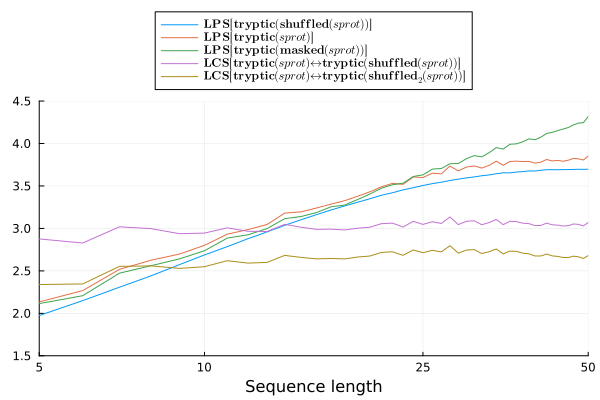

In [29]:
plot(yrange=(1.5, 4.5),
     xlabel="Sequence length",
     xrange=(5, 50),
     xticks=([5, 10, 25, 50], [5, 10, 25, 50]),
     xscale=:log2,
     legend=:outertop,
     dpi=500)
plot_LPS_distribution_matrix!(shuf_dist, trypticlpslabel(shuf(sprotall)))
plot_LPS_distribution_matrix!(sprot_dist, trypticlpslabel(sprotall))
plot_LPS_distribution_matrix!(hardmaskedsprot_dist, trypticlpslabel(mask(sprotall)))
plot_LCS_distribution_matrix!(lcs_dist, trypticlcslabel(sprotall, shuf(sprotall)))
plot_LCS_distribution_matrix!(lcs2_dist, trypticlcslabel(sprotall, shuf2(sprotall)))
savefig("figures/fig7_trypticpeptides.png")
plot!()

# A Better Benchmark?